In [1]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.optimize import curve_fit
from scipy import integrate as ig
from utils import bb

### Parameters

In [2]:
T = 293 # [K] ambient & cell temperature
h = 6.626 * 10**(-34) # [kgm^2/s]
h_2 = 4.1357*10**(-15) # eV s
c = 2.998 * 10**(8) # [m/s]
k = 1.3806 * 10**(-23) # [kgm^2/s^2K]
k_2 = 8.6173*10**(-5) # eV / K
q = 1.60217662 * 10**(-19) # [C]
q_eV = 1 
Vth = k_2*T/q_eV#thermal voltage [V]

### EL conversion functions
##### This could be included in the sEQE analysis and electroluminescence script

In [3]:
#converts spectrometer data (e.g. electroluminescence data) recorded as power flux vs wavenlength into photon flux vs energy
#input: (relative) spectrum [nm, ~W/nm] after calibration correction, for example EL
#output: dataframe with relative spectrum [eV, ~photons/(eVs)], ascending energies, index starting at 0
def convert_to_photon_flux(wavelength,power_flux):
    EE = h_2*c/q_eV / (wavelength*1e-9) #energy [eV]
    # conversion from [mW/(m^2nm)] to [photon number/(cm^2eVs)]; 
    # depending on input units prefactors would change
    # since often spectra are later normalized, all prefactors could be omitted and the input simply divided by E^3
    power_flux_pref = power_flux * 1e-3*1e-4*1e9 * h_2*c/q_eV# factor converting unit prefactors to output unit prefactors. 1e-3:mW-->W; 1e-4:m^2-->cm^2;   1e9:1/nm-->1/m; 
    photon_flux = power_flux_pref * h_2*c/q_eV * 1/(q*EE**3) # 1/q: W -->eV; 1/E: eV --> photon number; dLambda =hc/q*E^-2dE        
    
    spectrum = pd.DataFrame()
    spectrum['Energy'] = EE
    spectrum['photonFlux'] = photon_flux
    spectrum['photonFlux_norm'] = norm_spectrum(photon_flux)
    
    if spectrum['Energy'][0] > spectrum['Energy'].iloc[-1]:# convert to ascending energies
        spectrum = spectrum.iloc[::-1]
        spectrum = spectrum.set_index(pd.Index(range(len(spectrum))))# change index values to begin at 0 
   
    return spectrum    

In [4]:
# normalizes spectrum to maximum. Note: max might be influenced by noise
def norm_spectrum(spec):
    spec_norm = spec / np.max(spec)
    return spec_norm

In [5]:
# input: dataFrame with column 'Energy'
#return df slice
def select_energy_range(df, E_min = np.nan, E_max = np.nan):
    if np.isnan(E_min):
        E_min = np.amin(df['Energy'])
    if np.isnan(E_max):
        E_min = np.amax(df['Energy'])
    ind_sel = (df['Energy'] >= E_min) & (df['Energy'] <= E_max)
    df_slice = df[ind_sel]
    return df_slice

### Test code

In [6]:
codePath = os.getcwd()#only makes sense after kernel restart
codePath

'C:\\Users\\pasca\\Documents\\GitHub\\Voltage-Loss-Calculations'

In [7]:
os.chdir('C:/Users/pasca/OneDrive - Nexus365/Post/data/')#/home/jungbluth/Desktop/
os.getcwd()

'C:\\Users\\pasca\\OneDrive - Nexus365\\Post\\data'

In [8]:
def read_data(file, type, fac = 1):
    if type.lower() == 'el':
        EL_data = pd.read_csv(file, names=('no.', 'Wavelength', 'Signal'), header =1)
        spectrum = convert_to_photon_flux(EL_data['Wavelength'],EL_data['Signal'])
        
        spectrum['photonFlux_abs'] = spectrum['photonFlux_norm']*fac #scaled with reciprocity
        bbcell = bb(spectrum['Energy'])
        spectrum['EQE-from-EL'] = spectrum['photonFlux_abs']/bbcell['Phi'] 
        
    elif type.lower() == 'eqe':
        EQEdata = np.genfromtxt(file, skip_header = 1, delimiter = ',')
        spectrum = pd.DataFrame()
        spectrum['Energy'] = EQEdata[:,2]
        spectrum['EQE'] = EQEdata[:,3]*fac
        
    return spectrum

#### EL test and stitching

In [9]:
binFile = r'C:\Users\pasca\OneDrive - Nexus365\Post\data\PK210512_NFAbilayer-7\EL\bins_EL-A5.csv'
df = pd.read_csv(binFile, sep = ',') #uses .csv headers as column labels    

row = df.loc[0]
file = row['folder'] + '\\' + row['file']
spectrum_df = read_data(file, row['type'], 1)

bbcell = bb(spectrum_df['Energy'])
spectrum_df['EQE-from-EL'] = spectrum_df['photonFlux_norm']/bbcell['Phi']    

9.297920810791874e-07
9.617426296647404e-07
1.3581531350123615e-05


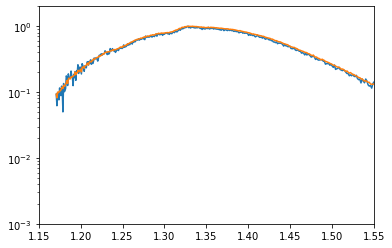

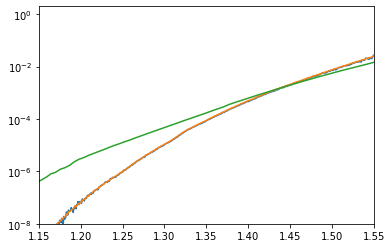

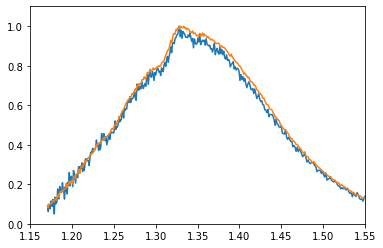

In [38]:
#Y6/ZnPc
#binFile = r'C:\Users\pasca\OneDrive - Nexus365\Post\data\PK210512_NFAbilayer-7\EL\bins_EL-A5.csv'
#Y6/F4ZnPc
binFile = r'C:\Users\pasca\OneDrive - Nexus365\Post\data\PK210408_NFAbilayer-3\EL\bins_EL-D1.csv'
df = pd.read_csv(binFile, sep = ',') #uses .csv headers as column labels    

E_scale = 1.25
EQEvals = np.zeros((len(df.index),1))

#row = df.loc[1]
#for row in df.loc[0]:
for ind, row in df.iterrows():
    file = row['folder'] + '\\' + row['file']
    spectrum_df = read_data(file, row['type'], row['fac'])
    
    
    ind_scale = (np.abs(spectrum_df['Energy']-E_scale)).argmin()
    if row['type'].lower()=='el':    
        EQEvals[ind] = spectrum_df.loc[ind_scale,'EQE-from-EL']
        print(spectrum_df.loc[ind_scale,'EQE-from-EL'])
    elif row['type'].lower()=='eqe':
        EQEvals[ind] = spectrum_df.loc[ind_scale,'EQE']
        print(spectrum_df.loc[ind_scale,'EQE'])
    
    plt.figure(1)
    #plt.plot(spectrum_df['Energy'],spectrum_df['photonFlux_norm'])
    if row['type'].lower()=='el':
        
        
        plt.semilogy(spectrum_df['Energy'],spectrum_df['photonFlux_norm'])
        plt.xlim([1.15,1.55])
        plt.ylim([1e-3,2])
        
    plt.figure(2)
    #plt.plot(spectrum_df['Energy'],spectrum_df['photonFlux_norm'])
    if row['type'].lower()=='el':
        plt.semilogy(spectrum_df['Energy'],spectrum_df['EQE-from-EL'])
    
    elif row['type'].lower()=='eqe':
        plt.semilogy(spectrum_df['Energy'],spectrum_df['EQE'])
    plt.xlim([1.15,1.55])
    plt.ylim([1e-8,2])
    
    plt.figure(3)
    if row['type'].lower()=='el':
        plt.plot(spectrum_df['Energy'],spectrum_df['photonFlux_norm'])
        plt.xlim([1.15,1.55])
        plt.ylim([0,1.1])
    
    

In [28]:
EQEvals

array([], shape=(6, 0), dtype=float64)

In [29]:
ind_scale

126

In [24]:

spectrum_df

,Energy,EQE
0,3.444435,3.090713e-02
1,3.397251,3.134516e-02
2,3.351343,3.122426e-02
3,3.306658,3.147888e-02
4,3.263149,3.083204e-02
...,...,...
164,1.050845,6.715257e-08
165,1.046411,8.071920e-08
166,1.042014,1.338380e-07
167,1.037654,1.320412e-07


(0.001, 2.0)

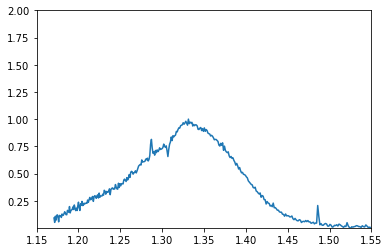

In [ ]:
##include: plot multiple EL files

#use calibration-corrected data for EL &sEQE
EL_scaling = 300
E_EL_min = np.nan
E_EL_max = 1.5

file_EL = 'PK210325_NFAbilayer/EL/data/Corrected_Files/A5_01_1V_5x30s.spm'
EL_data = pd.read_csv(file_EL, names=('no.', 'Wavelength', 'Signal'), header =1)
EL = convert_to_photon_flux(EL_data['Wavelength'],EL_data['Signal'])
EL = select_energy_range(EL, E_EL_min, E_EL_max)

# read sEQE data: returns dataFrame, ascending in energy with index values starting at 0 (for intuitive calling)
file_sEQE = 'PK210325_NFAbilayer/sEQE/A5_Y6-ZnPc'
sEQE_data = pd.read_csv(file_sEQE).iloc[::-1]# flip so df is ascending in energy
sEQE_data = sEQE_data.set_index(pd.Index(range(len(sEQE_data))))# change index values to begin at 0 

#test scaling
EQE_EL = EL_scaling * EL['photonFlux_norm'] / bb(EL['Energy'])['Phi']
plt.semilogy(sEQE_data['Energy'],sEQE_data['EQE'])
plt.semilogy(EL['Energy'],EL['photonFlux_norm']) #plot normalized EL spectrum with EQE 
plt.semilogy(EL['Energy'],EQE_EL)

In [ ]:
meas=pd.DataFrame()
meas['files'] = ['file1', 'file2','file3']
meas['V'] = [0.5, 1, 1.5]
a = np.array([5, 6, 7])
#meas['data'] = [a]
meas['V'].loc[0] = 0.2
#b = meas['V']

#a = [0.5, 1, 1.5]
#print(a)
#print(type(a))
#print(b)
#print(type(b))
#cc = np.array([0.5, 1, 1.5])
#meas['V'][0] = cc
#meas['V']
